In [1]:
%matplotlib inline

from utils.data_access_api import DataAccessApi
from utils.dc_utilities import write_geotiff_from_xr, write_png_from_xr
from utils.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.dc_mosaic import create_median_mosaic, create_mosaic
from utils.dc_sar_utils import dn_to_db 

from datetime import datetime
import xarray as xr
import gdal
import numpy as np

dc = DataAccessApi()

lat_range = (10.75, 11.25)
lon_range = (107.5, 108)
time_range = (datetime(2015,1,1), datetime(2017,1,1))

In [2]:
product = "s1a_gamma0_vietnam"
platform = "SENTINEL_1A"

In [3]:
dc.get_datacube_metadata(platform=platform,product=product)

{'lat_extents': (9.451534430335133, 14.773333836516002),
 'lon_extents': (106.55133180609833, 109.80008903111658),
 'pixel_count': 2142486930,
 'scene_count': 43,
 'time_extents': (datetime.datetime(2015, 2, 22, 22, 36, 7, 975000),
  datetime.datetime(2017, 1, 30, 22, 36, 42, 578000))}

In [4]:
product_details = dc.dc.list_products()[dc.dc.list_products().name == product]

acquisitions = dc.list_acquisition_dates(platform, product, time=time_range, 
                                         longitude=lon_range, latitude=lat_range)

geographic_chunks = create_geographic_chunks(latitude=lat_range, longitude=lon_range, geographic_chunk_size=.05)

In [5]:
measurements = ['vv', 'vh']
product_chunks = []

for index, chunk in enumerate(geographic_chunks):
    data = dc.get_dataset_by_extent(product, time=time_range, 
                                    longitude=chunk['longitude'], latitude=chunk['latitude'], 
                                    measurements=measurements)
    if 'vv' in data:
        product_chunks.append(create_median_mosaic(data, clean_mask=np.full((data.vv.shape), True), dtype="float32", no_data=0))
    
final_mosaic = combine_geographic_chunks(product_chunks)

dn_to_db(final_mosaic, data_vars=measurements, cf=0)

measurements.append('vv_vh')
final_mosaic['vv_vh'] = final_mosaic.vv / final_mosaic.vh


/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.9.5-py3.5.egg/xarray/core/duck_array_ops.py:48: RuntimeWarning: divide by zero encountered in log10
  return getattr(module, name)(*args, **kwargs)
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.9.5-py3.5.egg/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [6]:
write_geotiff_from_xr("s1a_products/s1a_median_mosaic.tif", final_mosaic, measurements, nodata=0)
write_png_from_xr("s1a_products/s1a_median_mosaic.png", final_mosaic, measurements, scale=[[-20,0], [-20,0], [0,1]], low_res=True)

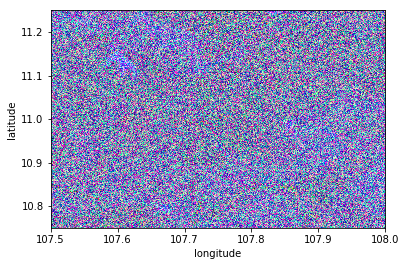

In [7]:
rgb = final_mosaic.to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension

rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
             col_wrap=5, add_colorbar=False)